In [430]:
# Installing libraries
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil.parser
import math
from datetime import date
from datetime import datetime, timedelta
from vega_datasets import data
import altair as alt
import squarify 
import re
import camelot
import numpy as np
alt.data_transformers.disable_max_rows()
#alt.data_transformers.enable('json')
pd.set_option('mode.chained_assignment', None)
pd.set_option("display.max_rows", 500)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

today = date.today()

# Data sources

This analysis is based on two different data sources that are structured differently and thus used to answer different questions as part of this analysis.

In the dataset provided by the **WHO**, each row corresponds to one developer and their vaccine candidate. In this analysis, this dataset (called "wf") is used to 
* show how many vaccine candidates are in which phase
* classify the vaccine candidates according to their type, and subsequently also phase


In the dataset compiled by the **London School of Hygiene and Tropical Medicine (LSHTM)**, each row corresponds to a registered clinical trial -- accordingly, a developer team testing their vaccine in multiple phases in parallel will see multiple entries in this dataset. In this analysis, this dataset (called "lf") is used to
* show trial sizes by company
* provide estimates (min, max, median) of the clinical phases

## How many vaccine candidates are there in each phase? (WHO data question)

In [431]:
wf = pd.read_csv('data/WHO-VaccineCandidates_2020-11-12.csv', delimiter = ';') #delimiter= ';'
wf.head()

,COVID-19 Vaccine developer/manufacturer,Vaccine platform,Preclinical,Phase 1,Phase 1/2,Phase 2,Phase 3
0,Sinovac,Inactivated,NaN,NaN,x,NaN,x
1,Wuhan Institute of Biological Products/Sinopharm,Inactivated,NaN,NaN,x,NaN,x
2,Beijing Institute of Biological Products/Sinop...,Inactivated,NaN,NaN,x,NaN,x
3,Bharat Biotech,Inactivated,NaN,NaN,x,NaN,x
4,University of Oxford/AstraZeneca,Non-Replicating Viral Vector,NaN,NaN,x,x,x


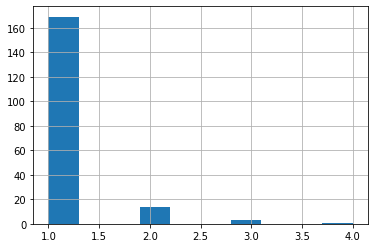

In [432]:
#the majority of developers only has one entry, thus only one vaccine candidate in the works
wf['COVID-19 Vaccine developer/manufacturer'].value_counts().hist()

In [433]:
#number of unique teams
wf['COVID-19 Vaccine developer/manufacturer'].nunique()

187

In [434]:
len(wf)

210

In [435]:
#display count of elements (not unique counts)
wf.describe().iloc[0]

COVID-19 Vaccine developer/manufacturer    210
Vaccine platform                           210
Preclinical                                162
Phase 1                                     29
Phase 1/2                                   23
Phase 2                                      9
Phase 3                                     11
Name: count, dtype: object

In [436]:
candidates_by_phase = wf.describe().iloc[0].rename_axis('Phase').reset_index(name='#_candidates-'+str(today))
#candidates_by_phase = candidates_by_phase.drop([0,1])
candidates_by_phase.to_csv('data/tracker-start.csv', index = False)
candidates_by_phase

,Phase,#_candidates-2020-11-26
0,COVID-19 Vaccine developer/manufacturer,210
1,Vaccine platform,210
2,Preclinical,162
3,Phase 1,29
4,Phase 1/2,23
5,Phase 2,9
6,Phase 3,11


In [437]:
# make timeline
candidates_phase_TL = pd.read_csv('data/tracker-start.csv')
#candidates_phase_TL = candidates_phase_TL.merge(candidates_by_phase, left_on='Phase', right_on='Phase')
candidates_phase_TL.to_csv('data/tracker-updated.csv')
candidates_phase_TL

,Phase,#_candidates-2020-11-26
0,COVID-19 Vaccine developer/manufacturer,210
1,Vaccine platform,210
2,Preclinical,162
3,Phase 1,29
4,Phase 1/2,23
5,Phase 2,9
6,Phase 3,11


## What vaccine types are investigated and how far along are they? (WHO data question)

In [438]:
# number of developers pursuing different platforms
wf.groupby(by='Vaccine platform')['COVID-19 Vaccine developer/manufacturer'].count().sort_values(ascending=False)

Vaccine platform
Protein Subunit                 70
RNA                             28
Non-Replicating Viral Vector    28
Replicating Viral Vector        21
Inactivated                     21
DNA                             19
VLP                             18
Live Attenuated Virus            3
T-cell based                     1
Replicating Bacteria Vector      1
Name: COVID-19 Vaccine developer/manufacturer, dtype: int64

In [439]:
# what is counted is whether the entry is not NaN - not how many elements an entry consists of
wf.groupby(by='Vaccine platform').count()

,COVID-19 Vaccine developer/manufacturer,Preclinical,Phase 1,Phase 1/2,Phase 2,Phase 3
Vaccine platform,,,,,,
DNA,19,14,1,4,0,0
Inactivated,21,14,2,7,0,4
Live Attenuated Virus,3,3,0,0,0,0
Non-Replicating Viral Vector,28,19,6,3,4,4
Protein Subunit,70,55,11,5,2,1
RNA,28,22,5,2,2,2
Replicating Bacteria Vector,1,1,0,0,0,0
Replicating Viral Vector,21,17,3,1,1,0
T-cell based,1,1,0,0,0,0


In [440]:
platforms = wf.groupby(by='Vaccine platform').count()
platforms = platforms[['Preclinical', 'Phase 1', 'Phase 1/2', 'Phase 2', 'Phase 3']]
platforms['Vaccine platform'] = platforms.index
platforms['sum_candidates_by_type'] = platforms['Preclinical'] + platforms['Phase 1'] +platforms['Phase 1/2'] +platforms['Phase 2'] +platforms['Phase 3']
platforms.sort_values(by='sum_candidates_by_type', ascending = False)
platforms = platforms[['Vaccine platform','sum_candidates_by_type','Preclinical', 'Phase 1', 'Phase 1/2', 'Phase 2', 'Phase 3']].reset_index(drop=True)
platforms.sort_values(by='sum_candidates_by_type', ascending =False)

,Vaccine platform,sum_candidates_by_type,Preclinical,Phase 1,Phase 1/2,Phase 2,Phase 3
4,Protein Subunit,74,55,11,5,2,1
3,Non-Replicating Viral Vector,36,19,6,3,4,4
5,RNA,33,22,5,2,2,2
1,Inactivated,27,14,2,7,0,4
7,Replicating Viral Vector,22,17,3,1,1,0
0,DNA,19,14,1,4,0,0
9,VLP,18,16,1,1,0,0
2,Live Attenuated Virus,3,3,0,0,0,0
6,Replicating Bacteria Vector,1,1,0,0,0,0
8,T-cell based,1,1,0,0,0,0


In [441]:
platform_plot = platforms.copy()
platform_plot = platform_plot[['Vaccine platform','Preclinical', 'Phase 1', 'Phase 1/2', 'Phase 2', 'Phase 3']]

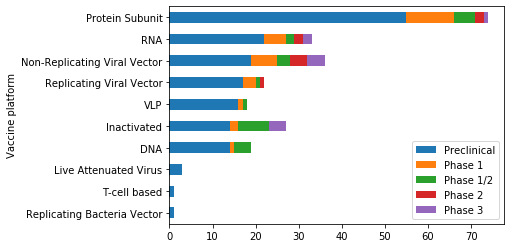

In [442]:
# make stacked bar of counts per phase 
columns=['Preclinical','Phase 1', 'Phase 1/2', 'Phase 2', 'Phase 3']
platform_plot.sort_values(by='Preclinical').plot(kind='barh', stacked=True, x='Vaccine platform')
plt.savefig('charts/drafts/vaccine_types-'+str(today)+'.pdf', transparent = True)

## How many trials does each research team run and what is their size? (LSHTM data question)

In [443]:
lf = pd.read_excel('data/VaC_LSHTM_Covid_vaccine_trials_11November2020.xlsx')
lf.head()

,Institutes,Phase,Vaccine,Platform,N,Age (years),N doses,Rand.,Design,Location,Start date,Primary completion date,Trial number,Status
0,Janssen Pharmaceutical Companies,Phase III,Janssen Ad26.COV2.S,Non-replicating viral vector,60000,≥18,1,Yes,Double-blind,"USA, Argentina, Brazil, others",07/09/2020,10/03/2023,NCT04505722,Recruiting
1,Beijing Institute of Biological Products/Wuhan...,Phase III,WIBP/BIBP/Sinopharm vaccines,Inactivated,45000,≥18,2,Yes,Double-blind,"Bahrain, Jordan, Egypt, UAE",16/07/2020,16/03/2021,NCT04510207,Recruiting
2,BioNTech/Fosun Pharma/Pfizer,Phase II/III,BioNTech BNT162 (b1/b2),RNA,43998,≥12,2,Yes,"Double-blind, dose-finding","USA, Argentina, Brazil, others",29/04/2020,13/06/2021,NCT04368728,Recruiting
3,University of Oxford/AstraZeneca,Phase III,Oxford ChAdOx1-S,Non-replicating viral vector,40051,≥18,2,Yes,Double-blind,"USA, Chile, Peru",28/08/2020,22/12/2020,NCT04516746,Recruiting
4,CanSino Biological Inc/Beijing Institute of Bi...,Phase III,Cansino Ad5-nCoV,Non-replicating viral vector,40000,≥18,1,Yes,Double-blind,Pakistan,15/09/2020,30/12/2021,NCT04526990,Recruiting


In [444]:
len(lf)

105

In [445]:
lf['Institutes'].value_counts()

University of Oxford/AstraZeneca                                                             9
Sinovac/Instituto Butantan                                                                   7
CanSino Biological Inc/Beijing Institute of Biotechnology                                    7
Gamaleya Research Institute                                                                  5
BioNTech/Fosun Pharma/Pfizer                                                                 5
Janssen Pharmaceutical Companies                                                             4
Novavax                                                                                      4
Bharat Biotech/ICMR/National Institute of Virology                                           3
Anhui Zhifei Longcom Biopharmaceutical/Chinese Academy of Sciences                           3
Moderna/NIAID                                                                                3
CureVac                                           

In [446]:
#number of research teams (not: single ones but counting conglomerates)
lf['Institutes'].nunique()

54

In [447]:
#total trial size by institute, irrespective of phase
lf.groupby(by='Institutes')['N'].sum().sort_values(ascending = False)

Institutes
Janssen Pharmaceutical Companies                                                             91295
University of Oxford/AstraZeneca                                                             64487
Beijing Institute of Biological Products/Wuhan Institute of Biological Products/Sinopharm    51000
BioNTech/Fosun Pharma/Pfizer                                                                 44878
Novavax                                                                                      44819
CanSino Biological Inc/Beijing Institute of Biotechnology                                    42382
Gamaleya Research Institute                                                                  40286
Moderna/NIAID                                                                                30720
Sinovac/Instituto Butantan                                                                   30438
Bharat Biotech/ICMR/National Institute of Virology                                           26879

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122c382b0>]],
      dtype=object)

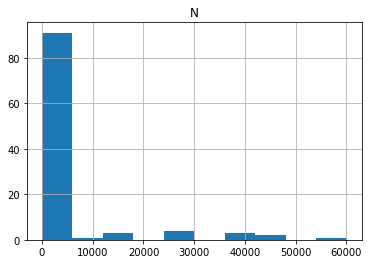

In [448]:
# distribution of trial sizes: The majority of research teams currently runs small trials
lf.hist()

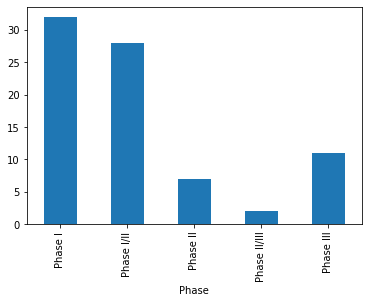

In [449]:
# number of research teams by phase
lf.groupby(by='Phase')['Institutes'].nunique().plot(kind='bar')
#plt.savefig('charts/drafts/Institutes_Phase.pdf', transparent = True)

In [450]:
lf.groupby(by=['Phase', 'Institutes'])['N'].sum()

Phase         Institutes                                                                               
Phase I       Adimmune Corporation                                                                            70
              Anhui Zhifei Longcom Biopharmaceutical/Chinese Academy of Sciences                              50
              Beijing Minhai Biotechnology Co Ltd                                                            180
              Beijing Wantai Biological Pharmacy/Xiamen University                                            60
              BioNTech/Fosun Pharma/Pfizer                                                                   144
              CanSino Biological Inc/Beijing Institute of Biotechnology                                      197
              Clover Biopharmaceuticals Inc/GSK/Dynavax                                                      150
              Codagenix/Serum Institute of India                                                         

In [451]:
phase1 = lf[lf['Phase']=='Phase I'].groupby(by='Institutes')['N'].sum().sort_values(ascending=False).rename_axis('Institutes').reset_index(name='total_trial_size_by_phase')
phase1['Phase'] = 'Phase I'

In [452]:
phase2 = lf[(lf['Phase']=='Phase II')|(lf['Phase']=='Phase I/II')].groupby(by='Institutes')['N'].sum().sort_values(ascending=False).rename_axis('Institutes').reset_index(name='total_trial_size_by_phase')
phase2['Phase'] = 'Phase II'

In [453]:
phase3 = lf[(lf['Phase']=='Phase III')|(lf['Phase']=='Phase II/III')].groupby(by='Institutes')['N'].sum().sort_values(ascending=False).rename_axis('Institutes').reset_index(name='total_trial_size_by_phase')
phase3['Phase'] = 'Phase III'

In [454]:
trials_df = pd.concat([phase1,phase2,phase3], ignore_index = True)
trials_df

,Institutes,total_trial_size_by_phase,Phase
0,Imperial College London,320,Phase I
1,PLA Academy of Military Sciences/Walvax Biotech,288,Phase I
2,CureVac,284,Phase I
3,IAVI/Merck,252,Phase I
4,Janssen Pharmaceutical Companies,250,Phase I
5,University of Queensland/CSL/Seqirus,216,Phase I
6,CanSino Biological Inc/Beijing Institute of Bi...,197,Phase I
7,Beijing Minhai Biotechnology Co Ltd,180,Phase I
8,Medicago Inc/GSK/Dynavax,180,Phase I
9,"West China Hospital,/Sichuan University",168,Phase I


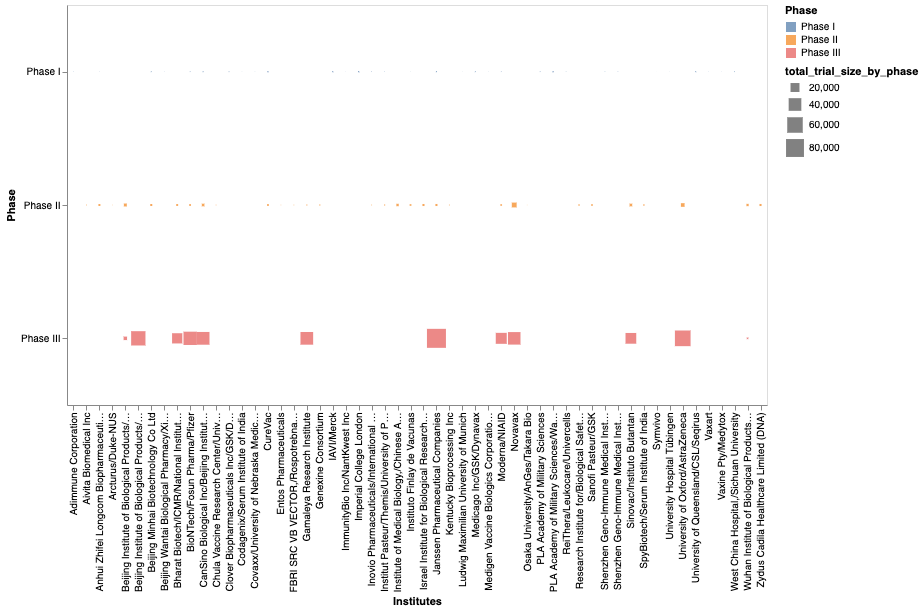

In [455]:
alt.Chart(trials_df).mark_square().encode(
    alt.Y('Phase:N', sort=None),
    alt.X('Institutes:N'),
    size='total_trial_size_by_phase:Q',
    color='Phase:N',
    tooltip=['N:Q']
).properties(width=700, height = 400)

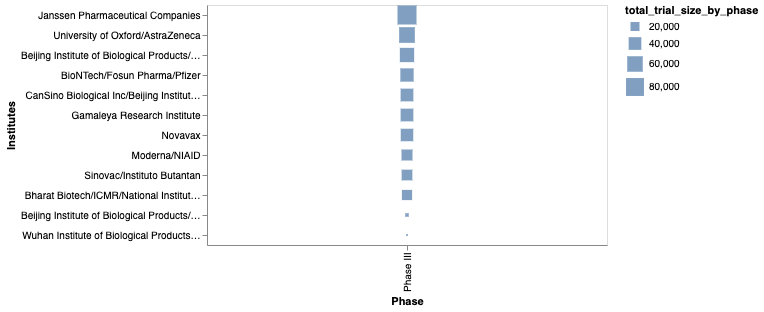

In [456]:
#make sorted phase three as addition for easier charting!

alt.Chart(phase3).mark_square().encode(
    alt.X('Phase:N'),
    alt.Y('Institutes:N', sort=None),
    size='total_trial_size_by_phase:Q',
    tooltip=['total_trial_size_by_phase:Q', 'Institutes:N']
).properties(width=400)

In [457]:
# round to nearest thousand
phase3['total_trial_size_by_phase_ROUNDED'] = phase3['total_trial_size_by_phase'].round(decimals=-3)
phase3

,Institutes,total_trial_size_by_phase,Phase,total_trial_size_by_phase_ROUNDED
0,Janssen Pharmaceutical Companies,90000,Phase III,90000
1,University of Oxford/AstraZeneca,61141,Phase III,61000
2,Beijing Institute of Biological Products/Wuhan...,51000,Phase III,51000
3,BioNTech/Fosun Pharma/Pfizer,43998,Phase III,44000
4,CanSino Biological Inc/Beijing Institute of Bi...,40500,Phase III,40000
5,Gamaleya Research Institute,40100,Phase III,40000
6,Novavax,39000,Phase III,39000
7,Moderna/NIAID,30000,Phase III,30000
8,Sinovac/Instituto Butantan,28720,Phase III,29000
9,Bharat Biotech/ICMR/National Institute of Viro...,26000,Phase III,26000


In [458]:
# explore data in more granular detail
lf[(lf['Phase']=='Phase III')|(lf['Phase']=='Phase II/III')].sort_values(by='N', ascending = False)

,Institutes,Phase,Vaccine,Platform,N,Age (years),N doses,Rand.,Design,Location,Start date,Primary completion date,Trial number,Status
0,Janssen Pharmaceutical Companies,Phase III,Janssen Ad26.COV2.S,Non-replicating viral vector,60000,≥18,1,Yes,Double-blind,"USA, Argentina, Brazil, others",07/09/2020,10/03/2023,NCT04505722,Recruiting
1,Beijing Institute of Biological Products/Wuhan...,Phase III,WIBP/BIBP/Sinopharm vaccines,Inactivated,45000,≥18,2,Yes,Double-blind,"Bahrain, Jordan, Egypt, UAE",16/07/2020,16/03/2021,NCT04510207,Recruiting
2,BioNTech/Fosun Pharma/Pfizer,Phase II/III,BioNTech BNT162 (b1/b2),RNA,43998,≥12,2,Yes,"Double-blind, dose-finding","USA, Argentina, Brazil, others",29/04/2020,13/06/2021,NCT04368728,Recruiting
3,University of Oxford/AstraZeneca,Phase III,Oxford ChAdOx1-S,Non-replicating viral vector,40051,≥18,2,Yes,Double-blind,"USA, Chile, Peru",28/08/2020,22/12/2020,NCT04516746,Recruiting
4,CanSino Biological Inc/Beijing Institute of Bi...,Phase III,Cansino Ad5-nCoV,Non-replicating viral vector,40000,≥18,1,Yes,Double-blind,Pakistan,15/09/2020,30/12/2021,NCT04526990,Recruiting
5,Gamaleya Research Institute,Phase III,Gamaleya Gam-COVID-Vac,Non-replicating viral vector,40000,≥18,2,Yes,Double-blind,Russia,07/09/2020,01/05/2021,NCT04530396,Recruiting
6,Moderna/NIAID,Phase III,Moderna mRNA-1273,RNA,30000,≥18,2,Yes,Double-blind,USA,27/07/2020,27/10/2022,NCT04470427,"Active, not recruiting"
7,Novavax,Phase III,Novavax NVX-CoV2373,Protein subunit,30000,≥18,2,Yes,Double-blind,"USA, Mexico, Puerto Rico",01/11/2020,31/03/2021,NCT04611802,Not yet recruiting
8,Janssen Pharmaceutical Companies,Phase III,Janssen Ad26.COV2.S,Non-replicating viral vector,30000,≥18,2,Yes,Double-blind,"USA, Belgium, Colombia, others",06/11/2020,10/05/2021,NCT04614948,Not yet recruiting
9,Bharat Biotech/ICMR/National Institute of Viro...,Phase III,Bharat COVAXIN,Inactivated,26000,Pending,Pending,Pending,Pending,Pending,10/11/2020,Pending,Pending,Recruiting


## How long will trials take, according to researchers estimates? (LSHTM data question)


In [459]:
# prep: calculate time ranges: min, max, median
tf = lf.copy()
tf.head()

,Institutes,Phase,Vaccine,Platform,N,Age (years),N doses,Rand.,Design,Location,Start date,Primary completion date,Trial number,Status
0,Janssen Pharmaceutical Companies,Phase III,Janssen Ad26.COV2.S,Non-replicating viral vector,60000,≥18,1,Yes,Double-blind,"USA, Argentina, Brazil, others",07/09/2020,10/03/2023,NCT04505722,Recruiting
1,Beijing Institute of Biological Products/Wuhan...,Phase III,WIBP/BIBP/Sinopharm vaccines,Inactivated,45000,≥18,2,Yes,Double-blind,"Bahrain, Jordan, Egypt, UAE",16/07/2020,16/03/2021,NCT04510207,Recruiting
2,BioNTech/Fosun Pharma/Pfizer,Phase II/III,BioNTech BNT162 (b1/b2),RNA,43998,≥12,2,Yes,"Double-blind, dose-finding","USA, Argentina, Brazil, others",29/04/2020,13/06/2021,NCT04368728,Recruiting
3,University of Oxford/AstraZeneca,Phase III,Oxford ChAdOx1-S,Non-replicating viral vector,40051,≥18,2,Yes,Double-blind,"USA, Chile, Peru",28/08/2020,22/12/2020,NCT04516746,Recruiting
4,CanSino Biological Inc/Beijing Institute of Bi...,Phase III,Cansino Ad5-nCoV,Non-replicating viral vector,40000,≥18,1,Yes,Double-blind,Pakistan,15/09/2020,30/12/2021,NCT04526990,Recruiting


In [460]:
#convert columns to time 
tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 14 columns):
Institutes                 105 non-null object
Phase                      105 non-null object
Vaccine                    105 non-null object
Platform                   105 non-null object
N                          105 non-null int64
Age (years)                105 non-null object
N doses                    105 non-null object
Rand.                      105 non-null object
Design                     105 non-null object
Location                   105 non-null object
Start date                 105 non-null object
Primary completion date    105 non-null object
Trial number               105 non-null object
Status                     105 non-null object
dtypes: int64(1), object(13)
memory usage: 11.6+ KB


In [461]:
tf['parsed_start'] = [re.sub(r'(\d\d)\/(\d\d)\/(\d\d\d\d)','\g<3>-\g<2>-\g<1>', date) for date in tf['Start date']]
tf['parsed_primary_completion'] = [re.sub(r'(\d\d)\/(\d\d)\/(\d\d\d\d)','\g<3>-\g<2>-\g<1>', date) for date in tf['Primary completion date']]
tf.head()

,Institutes,Phase,Vaccine,Platform,N,Age (years),N doses,Rand.,Design,Location,Start date,Primary completion date,Trial number,Status,parsed_start,parsed_primary_completion
0,Janssen Pharmaceutical Companies,Phase III,Janssen Ad26.COV2.S,Non-replicating viral vector,60000,≥18,1,Yes,Double-blind,"USA, Argentina, Brazil, others",07/09/2020,10/03/2023,NCT04505722,Recruiting,2020-09-07,2023-03-10
1,Beijing Institute of Biological Products/Wuhan...,Phase III,WIBP/BIBP/Sinopharm vaccines,Inactivated,45000,≥18,2,Yes,Double-blind,"Bahrain, Jordan, Egypt, UAE",16/07/2020,16/03/2021,NCT04510207,Recruiting,2020-07-16,2021-03-16
2,BioNTech/Fosun Pharma/Pfizer,Phase II/III,BioNTech BNT162 (b1/b2),RNA,43998,≥12,2,Yes,"Double-blind, dose-finding","USA, Argentina, Brazil, others",29/04/2020,13/06/2021,NCT04368728,Recruiting,2020-04-29,2021-06-13
3,University of Oxford/AstraZeneca,Phase III,Oxford ChAdOx1-S,Non-replicating viral vector,40051,≥18,2,Yes,Double-blind,"USA, Chile, Peru",28/08/2020,22/12/2020,NCT04516746,Recruiting,2020-08-28,2020-12-22
4,CanSino Biological Inc/Beijing Institute of Bi...,Phase III,Cansino Ad5-nCoV,Non-replicating viral vector,40000,≥18,1,Yes,Double-blind,Pakistan,15/09/2020,30/12/2021,NCT04526990,Recruiting,2020-09-15,2021-12-30


In [462]:
tf['parsed_start'] = [datetime.strptime(date, '%Y-%m-%d') for date in tf['parsed_start']]

In [463]:
for date in tf['parsed_primary_completion']:
    try:
        tf['parsed_primary_completion'] = datetime.strptime(date, '%Y-%m-%d')
    except:
        pass

In [464]:
# calculate time ranges: min, max, median
tf['timespan'] = tf['parsed_primary_completion'] - tf['parsed_start'] 

In [465]:
tf.head()

,Institutes,Phase,Vaccine,Platform,N,Age (years),N doses,Rand.,Design,Location,Start date,Primary completion date,Trial number,Status,parsed_start,parsed_primary_completion,timespan
0,Janssen Pharmaceutical Companies,Phase III,Janssen Ad26.COV2.S,Non-replicating viral vector,60000,≥18,1,Yes,Double-blind,"USA, Argentina, Brazil, others",07/09/2020,10/03/2023,NCT04505722,Recruiting,2020-09-07,2021-12-30,479 days
1,Beijing Institute of Biological Products/Wuhan...,Phase III,WIBP/BIBP/Sinopharm vaccines,Inactivated,45000,≥18,2,Yes,Double-blind,"Bahrain, Jordan, Egypt, UAE",16/07/2020,16/03/2021,NCT04510207,Recruiting,2020-07-16,2021-12-30,532 days
2,BioNTech/Fosun Pharma/Pfizer,Phase II/III,BioNTech BNT162 (b1/b2),RNA,43998,≥12,2,Yes,"Double-blind, dose-finding","USA, Argentina, Brazil, others",29/04/2020,13/06/2021,NCT04368728,Recruiting,2020-04-29,2021-12-30,610 days
3,University of Oxford/AstraZeneca,Phase III,Oxford ChAdOx1-S,Non-replicating viral vector,40051,≥18,2,Yes,Double-blind,"USA, Chile, Peru",28/08/2020,22/12/2020,NCT04516746,Recruiting,2020-08-28,2021-12-30,489 days
4,CanSino Biological Inc/Beijing Institute of Bi...,Phase III,Cansino Ad5-nCoV,Non-replicating viral vector,40000,≥18,1,Yes,Double-blind,Pakistan,15/09/2020,30/12/2021,NCT04526990,Recruiting,2020-09-15,2021-12-30,471 days


In [466]:
timespans = tf['timespan'].describe().rename_axis('stat_measure').reset_index(name='duration_days')
timespans=timespans.drop([0])
timespans

,stat_measure,duration_days
1,mean,511 days 02:17:08.571428
2,std,67 days 04:02:00.545199
3,min,363 days 00:00:00
4,25%,460 days 00:00:00
5,50%,495 days 00:00:00
6,75%,554 days 00:00:00
7,max,684 days 00:00:00


In [467]:
#https://www.datasciencemadesimple.com/difference-two-dates-days-weeks-months-years-pandas-python-2/
timespans['months_rounded'] = round(timespans['duration_days']/np.timedelta64(1,'M'))
timespans['months'] = round(timespans['duration_days']/np.timedelta64(1,'M'))
timespans['years'] = timespans['duration_days']/np.timedelta64(1,'Y')
timespans['days'] = timespans['duration_days']/np.timedelta64(1,'D')
timespans.to_csv('data/data-exports/timespans-'+str(today)+'.csv', index = False)
timespans

,stat_measure,duration_days,months_rounded,months,years,days
1,mean,511 days 02:17:08.571428,17.0,17.0,1.399331,511.095238
2,std,67 days 04:02:00.545199,2.0,2.0,0.183900,67.168062
3,min,363 days 00:00:00,12.0,12.0,0.993860,363.000000
4,25%,460 days 00:00:00,15.0,15.0,1.259437,460.000000
5,50%,495 days 00:00:00,16.0,16.0,1.355264,495.000000
6,75%,554 days 00:00:00,18.0,18.0,1.516800,554.000000
7,max,684 days 00:00:00,22.0,22.0,1.872728,684.000000


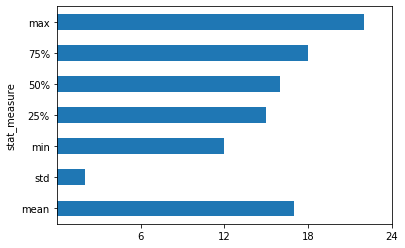

In [468]:
# visualize as bar chart
timespans.plot(kind='barh', y='months', x='stat_measure', legend = False, xticks=[6,12,18,24])
plt.savefig('charts/drafts/trial-duration-'+str(today)+'.pdf', transparent = True)